In [1]:
import sys
sys.path.insert(0, '../../')

import pandas as pd
from preprocess import Audio_Processor
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from data_utils import enumerate_strings, balanced_subsample
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%load_ext memory_profiler
%load_ext line_profiler

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

# Load Dataset

In [5]:
path_to_db='../../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]
    

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [6]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        feature_bag=False,
                        folds=5
                       )

df = df[df.h_target == 0]
red_class = [classes[i] for i in df.target.unique()]
df.head()

,target,h_target,metadata,fold
0,0,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfcc...,1
1,14,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,2
8,9,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,5
14,0,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfcc...,1
29,8,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,3


In [7]:
train = ps.bag_of_features(df[df.fold != 1].reset_index())
train.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,81.355627,60.950895,35.026463,48.047609,53.739915,42.014673,48.515288,36.766431,53.463175,52.233060,...,0.425719,0.243835,12.205491,13.338520,5.419358,15.416913,3.034387,0,14,2
1,82.090071,66.576588,44.457472,43.406209,51.750090,33.061378,44.813918,43.999085,45.518410,41.850523,...,-0.012500,0.257141,9.483506,12.958784,4.558367,15.372567,2.792519,0,14,2
2,84.208982,62.966970,46.823424,37.631471,47.758099,42.029236,54.039877,44.406314,43.668848,47.363946,...,0.079334,0.517184,12.201532,11.095703,4.802391,15.916300,3.168262,0,14,2
3,70.073610,82.465856,47.496273,57.899457,57.234505,36.226570,59.486281,44.904293,37.335008,41.632832,...,0.297949,0.001637,9.933414,15.130064,4.932393,18.708356,3.396824,0,14,2
4,64.759162,101.448273,69.353902,61.032527,48.199999,48.181578,57.047702,46.993057,49.225614,39.971573,...,0.186153,0.195547,15.884816,10.161794,5.320202,13.979928,3.583472,0,14,2


In [8]:
test = ps.bag_of_features(df[df.fold == 1].reset_index())
test.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,52.009557,4.327045,5.696827,6.522973,3.426770,9.314700,8.897445,1.613144,3.654356,6.125930,...,-0.430331,0.430331,29.442891,33.986595,7.463287,129.495423,54.772801,0,0,1
1,88.404377,82.645071,55.548627,51.936489,32.090942,23.103625,23.082517,18.536499,16.418501,15.469806,...,0.475820,-0.102448,15.695233,20.199985,3.943083,20.152053,1.728330,0,0,1
2,86.987377,78.083572,51.433488,51.561430,33.107803,31.318922,21.869279,15.681414,22.181496,16.827397,...,0.254841,0.158864,14.345672,19.755847,3.758124,17.172734,1.683485,0,0,1
3,80.670230,68.750011,19.582458,23.847321,18.158782,20.392203,9.204180,11.268402,12.634953,12.072391,...,0.278538,0.105655,25.330133,34.365584,4.991139,27.321271,10.232799,0,0,1
4,85.754845,98.029156,49.788149,58.918382,40.791330,36.997772,26.427850,25.393372,32.453010,23.418101,...,0.277774,-0.122589,11.128216,15.240660,3.980545,16.944237,1.344349,0,0,1


In [9]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train['target']
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test['target']

# Training

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import scipy

params = {
    'classify__n_estimators': range(5,100,1),
    'classify__criterion': ('gini', 'entropy'),
    'classify__max_depth': range(len(df.columns), 5 * len(df.columns)),
    'classify__max_features': ('log2', 'auto', None),
    'classify__oob_score': (True, False),
    'classify__warm_start': (True, False)
}

clf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feat_sel', SelectKBest(k=90, score_func=chi2)),
    ('feat_red', LinearDiscriminantAnalysis(n_components=20, solver='eigen')),
    ('classify', RandomForestClassifier(n_jobs=10, random_state=42))
])

randsrc = RandomizedSearchCV(
                clf,
                cv=10,
                refit=True,
                param_distributions = params,
                verbose=2,
                n_jobs=10,
                n_iter=100
)

randsrc.fit(train_X, train_y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   29.7s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:  8.9min
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed: 13.9min
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed: 19.0min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=90, score_func=<function chi2 at 0x7fde25f2b378>)), ('feat_red', LinearDiscriminantAnalysis(n_components=20, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001)), (...tors='warn', n_jobs=10,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=10,
          param_distributions={'classify__max_depth': range(4, 20), 'classify__max_features': ('log2', 'auto', None), 'classify__criterion': ('gini', 'entropy'), 'classify__n_estimators': range(5, 100), 'classify__oob_score': (True, False), 'classify__warm_start': (True, False)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [12]:
randsrc.best_estimator_ 

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=90, score_func=<function chi2 at 0x7fde25f2b378>)), ('feat_red', LinearDiscriminantAnalysis(n_components=20, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001)), (...timators=99, n_jobs=10,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [13]:
sorted(randsrc.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_classify__criterion',
 'param_classify__max_depth',
 'param_classify__max_features',
 'param_classify__n_estimators',
 'param_classify__oob_score',
 'param_classify__warm_start',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'split5_test_score',
 'split5_train_score',
 'split6_test_score',
 'split6_train_score',
 'split7_test_score',
 'split7_train_score',
 'split8_test_score',
 'split8_train_score',
 'split9_test_score',
 'split9_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

0.39491004826678366
Confusion matrix, without normalization
[[85  5  2  3  4  6 15  0  0  3  0  0  1 26  3 24  6  3]
 [ 2 44  0  3  3  6  3  0  0  0  0  2  5 16  1  7  4  3]
 [ 0  0 40  0  5  0  4  3  6 11  1  5 12  3 11  4  3  8]
 [ 2  4  3 75  4  6  4 21 26  3  0  2  2  3  2  4  2 24]
 [ 7  0  0  1 71  6  5  5  4 15 11  5  1  0  1  0  1  0]
 [ 7  7  2 11  4 30  4  5  3  5  0  2  6  2  1  4  1  7]
 [ 9  1 10  3  5  8 52 14  3  9  4  9 15  4  2  0  3  1]
 [ 0  2  2  5  1  4  1 48  9  3 10 10  4  1  0  0  0 14]
 [ 0  6  9 17  5  4  0 14 39 10  1 12 15  0 12  2  4 34]
 [ 0  5  2  0 10  5  0  4  4 46  1  3  9  6  8  3  0  5]
 [ 0  0  0  2  0  1  0 10  1  0 71 29  0  0  0  0  0  0]
 [ 0  0  2  0  2  6  5  8  1 10 31 61  0  0  2  0  5  0]
 [ 0  6  9  8  3 18  8  1  4  5  0  4 70  2 10  0  6 13]
 [ 0  3  3  0  0  0  0  0  0  2  0  0  2 52  3  7  0  5]
 [ 0  1  3  6  0  1  0  0  1  4  0  0  5  1 31  4  0 19]
 [16  2  2  2  1  2  1  0  0  2  0  0  2 11  2 26 10  6]
 [ 9 12  9  6 19  5 33 16  6

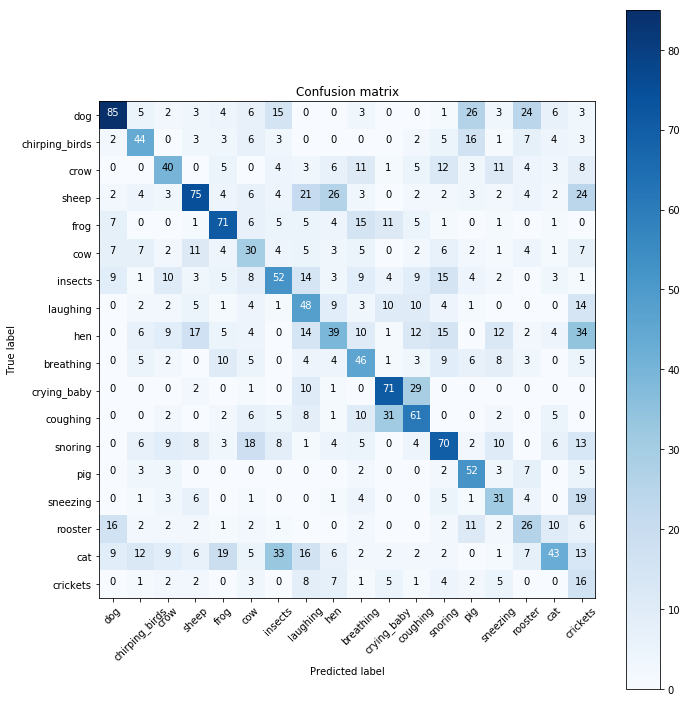

In [14]:
pred = randsrc.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, red_class)
plt.show()

In [16]:
pred_prob = randsrc.predict_proba(test_X)

# All Data

In [17]:
import seaborn as sns
misclassified = {
    'actual': [],
    'predicted': []
}
for cls in red_class:
    misclassified[cls] = []

for row, p, prob, Y in zip(test.iterrows(), pred, pred_prob, test_y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['actual'].append(classes[int(row[1]['target'])])
        misclassified['predicted'].append(classes[p])
        for i, cls in enumerate(red_class):
            misclassified[cls].append(prob[i])

misclassified = pd.DataFrame.from_dict(misclassified)
misclassified.head()

,actual,breathing,cat,chirping_birds,coughing,cow,crickets,crow,crying_baby,dog,frog,hen,insects,laughing,pig,predicted,rooster,sheep,sneezing,snoring
0,dog,0.030808,0.061472,0.001443,0.010101,0.064574,0.160173,0.034199,0.000000,0.033911,0.040404,0.032107,0.076840,0.076984,0.015873,snoring,0.101371,0.145815,0.011328,0.102597
1,dog,0.020202,0.010101,0.000000,0.010101,0.161964,0.080808,0.020202,0.010101,0.080808,0.080808,0.030303,0.090909,0.101010,0.020202,cat,0.070707,0.130268,0.030303,0.051202
2,dog,0.020202,0.010101,0.000000,0.020202,0.161964,0.070707,0.010101,0.000000,0.101010,0.080808,0.050505,0.111111,0.080808,0.010101,cat,0.070707,0.110066,0.010101,0.081505
3,dog,0.030303,0.030303,0.020202,0.000000,0.181818,0.040404,0.030303,0.000000,0.169697,0.050505,0.010101,0.101010,0.070707,0.012121,cat,0.070707,0.141414,0.020202,0.020202
4,dog,0.010101,0.030303,0.010101,0.000000,0.020202,0.010101,0.010101,0.000000,0.080662,0.000000,0.000000,0.000505,0.010101,0.737374,sneezing,0.050146,0.030303,0.000000,0.000000


In [18]:
average_prob = misclassified.groupby('actual').mean()
average_prob.head()

,breathing,cat,chirping_birds,coughing,cow,crickets,crow,crying_baby,dog,frog,hen,insects,laughing,pig,rooster,sheep,sneezing,snoring
actual,,,,,,,,,,,,,,,,,,
breathing,0.044031,0.052295,0.048010,0.011599,0.037606,0.201230,0.063138,0.004953,0.015129,0.013079,0.065145,0.021090,0.035601,0.044250,0.060974,0.099156,0.117885,0.064829
cat,0.050785,0.053879,0.065480,0.024606,0.082505,0.075731,0.046611,0.013448,0.073365,0.057003,0.058579,0.056388,0.067546,0.041274,0.053188,0.089662,0.036125,0.053825
chirping_birds,0.094434,0.055368,0.011155,0.112405,0.039515,0.027206,0.050204,0.264432,0.015197,0.046677,0.049041,0.055840,0.086632,0.009427,0.012365,0.012887,0.023896,0.033318
coughing,0.035417,0.087127,0.080117,0.009121,0.052584,0.066474,0.040116,0.007546,0.131178,0.034677,0.019147,0.057276,0.028311,0.099126,0.121822,0.044843,0.047913,0.037203
cow,0.039057,0.046585,0.033783,0.024176,0.066967,0.116779,0.057776,0.008469,0.022622,0.035364,0.123927,0.044972,0.110426,0.026810,0.031495,0.120645,0.052485,0.037665


In [19]:
average_prob = misclassified.groupby('predicted').mean()
average_prob

,breathing,cat,chirping_birds,coughing,cow,crickets,crow,crying_baby,dog,frog,hen,insects,laughing,pig,rooster,sheep,sneezing,snoring
predicted,,,,,,,,,,,,,,,,,,
breathing,0.081553,0.021180,0.020468,0.012355,0.035047,0.101219,0.109010,0.007483,0.017788,0.026942,0.054005,0.016634,0.034238,0.041645,0.042533,0.033809,0.279039,0.065052
cat,0.048664,0.044033,0.047813,0.024395,0.217982,0.064738,0.037292,0.014406,0.038137,0.040463,0.062835,0.063011,0.088556,0.020360,0.024933,0.063191,0.028623,0.070568
chirping_birds,0.071573,0.028894,0.017174,0.383597,0.024950,0.020285,0.047742,0.159996,0.005451,0.049482,0.038179,0.034847,0.064776,0.008788,0.006960,0.006104,0.008986,0.022217
coughing,0.020562,0.060872,0.071379,0.009435,0.027183,0.087229,0.049210,0.008736,0.068083,0.013272,0.017758,0.017503,0.024426,0.121358,0.262680,0.053250,0.057667,0.029396
cow,0.021540,0.056614,0.058592,0.005514,0.056878,0.095562,0.035798,0.004647,0.025333,0.025892,0.109542,0.022857,0.079583,0.019314,0.023544,0.290569,0.039531,0.028690
crickets,0.072700,0.019374,0.017927,0.159144,0.023577,0.022676,0.021954,0.442490,0.007237,0.042619,0.033291,0.018968,0.083898,0.004885,0.002080,0.008819,0.011427,0.006934
crow,0.251891,0.022747,0.023456,0.071038,0.049529,0.042359,0.043890,0.041172,0.023216,0.081428,0.086785,0.037786,0.052915,0.025124,0.018244,0.027483,0.058298,0.042637
crying_baby,0.048458,0.059249,0.043333,0.028295,0.076975,0.052976,0.073429,0.004616,0.015392,0.025049,0.046672,0.067359,0.048271,0.029222,0.033491,0.031286,0.040939,0.274990
dog,0.035968,0.067898,0.046310,0.005947,0.056243,0.024565,0.022261,0.006370,0.332733,0.101232,0.010452,0.093856,0.016737,0.039526,0.070020,0.026559,0.016394,0.026930


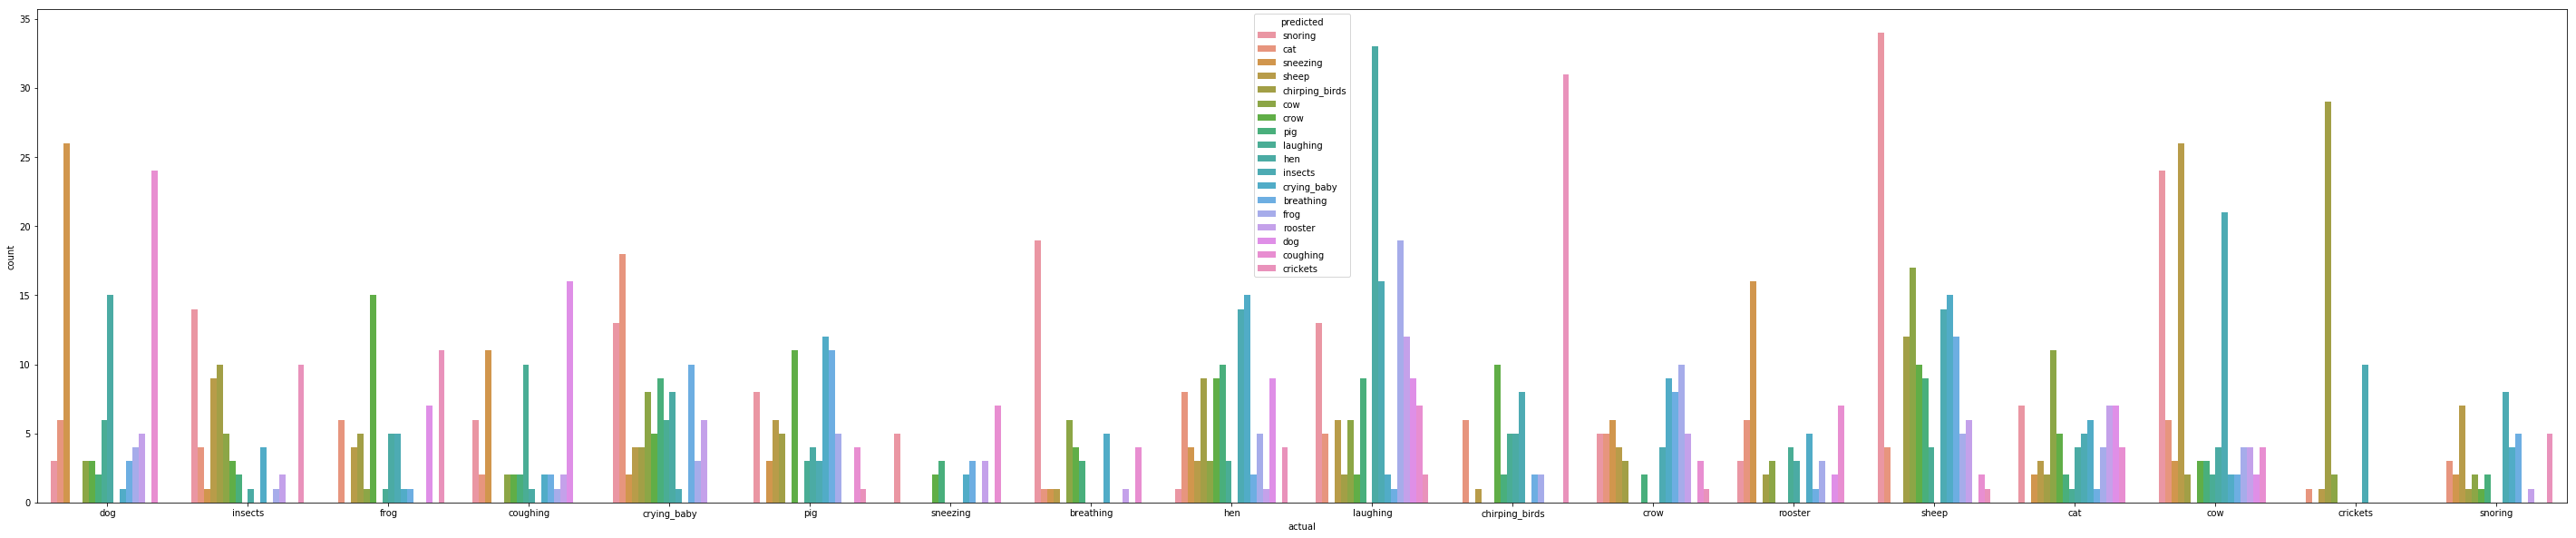

In [20]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(50,10))
sns.countplot(x='actual', hue='predicted',data=misclassified)